In [20]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

In [21]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

In [22]:
train_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True) 
test_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True)

In [23]:
train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

In [24]:
train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

In [25]:
train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 1 else 1)
test_df['label'] = -1

In [26]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stopwords = TfidfVectorizer(stop_words='english').get_stop_words()
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

    # Define the text and relevant variables column transformer with SelectKBest
text_and_vars_transformer = ColumnTransformer([
    ('text', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'reviewText'),
    ('summary', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'summary'),
    ('verified', OneHotEncoder(), ['verified']), # Encode the 'verified' column
    ('vote', 'passthrough', ['vote'])
])

# Split the training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Concatenate the text data with other relevant variables
train_features = text_and_vars_transformer.fit_transform(train_df[['reviewText', 'summary', 'verified', 'vote']])
valid_features = text_and_vars_transformer.transform(valid_df[['reviewText', 'summary', 'verified', 'vote']])
test_features = text_and_vars_transformer.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label = train_df['label']
valid_label = valid_df['label']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average Score: 0.7807512293460743  Standard Deviation: 0.0035537507716771493  for {'C': 0.001}
Average Score: 0.8244439376354803  Standard Deviation: 0.005119281400551445  for {'C': 0.01}
Average Score: 0.8813775844236422  Standard Deviation: 0.0039302888884414884  for {'C': 0.1}
Average Score: 0.9006353769169472  Standard Deviation: 0.002578976579608535  for {'C': 1}
Average Score: 0.8999818078433508  Standard Deviation: 0.00206847643474819  for {'C': 10}
Average Score: 0.8958515833013905  Standard Deviation: 0.00232436137543143  for {'C': 100}

Logistic Regression Classifier:
Optimal Hyperparameters: {'C': 1}
Maximum AUC Score: 0.9006353769169472

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.45      0.58      1233
           1       0.87      0.97      0.92      4605

    accuracy                           0.86      5838
   macro avg       0.84      0.71      0.75      5838
weighted avg       0.86      

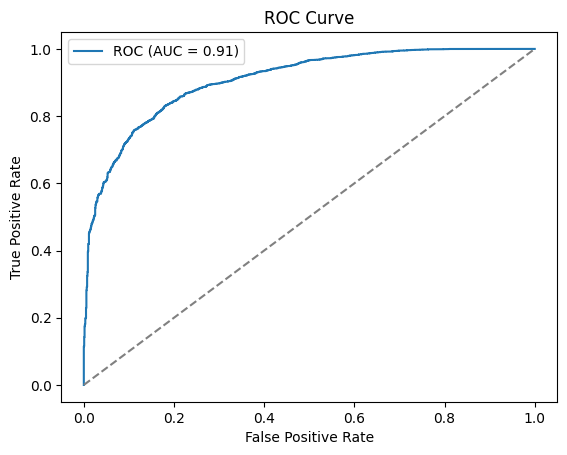

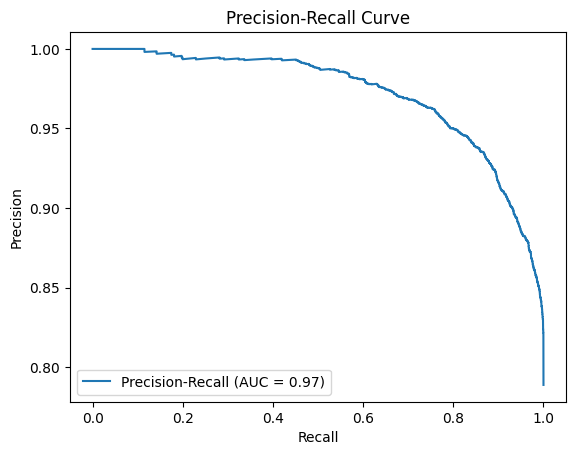

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV

# Logistic Regression Classifier setup
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Hyperparameters for Logistic Regression
logreg_hyperparameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Grid search with 5-fold cross-validation
logreg_cv_grid = GridSearchCV(log_reg, logreg_hyperparameters, cv=5, scoring='roc_auc')
logreg_cv_grid.fit(train_features, train_label)

# Cross-validation results
cv_outcomes_logreg = logreg_cv_grid.cv_results_
for avg_score, std_score, hyperparam in zip(cv_outcomes_logreg['mean_test_score'], cv_outcomes_logreg['std_test_score'], cv_outcomes_logreg['params']):
    print("Average Score:", avg_score, " Standard Deviation:", std_score, " for", hyperparam)

# Best parameters and score
print('\nLogistic Regression Classifier:')
print('Optimal Hyperparameters:', logreg_cv_grid.best_params_)
print('Maximum AUC Score:', logreg_cv_grid.best_score_)

# Model evaluation
optimal_logreg = logreg_cv_grid.best_estimator_
valid_prediction_logreg = optimal_logreg.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_prediction_logreg))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_prediction_logreg))
print('Accuracy:', accuracy_score(valid_label, valid_prediction_logreg))
print('AUC Score:', roc_auc_score(valid_label, optimal_logreg.predict_proba(valid_features)[:,1]))

# ROC curve
fpr_logreg, tpr_logreg, _ = roc_curve(valid_label, optimal_logreg.predict_proba(valid_features)[:,1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'ROC (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision_logreg, recall_logreg, _ = precision_recall_curve(valid_label, optimal_logreg.predict_proba(valid_features)[:,1])
prc_auc_logreg = auc(recall_logreg, precision_logreg)
plt.figure()
plt.plot(recall_logreg, precision_logreg, label=f'Precision-Recall (AUC = {prc_auc_logreg:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# Predict on test set and save to csv
test_prediction_logreg = optimal_logreg.predict(test_features)
test_df['binary_split_2'] = test_prediction_logreg
result_df_logreg = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
result_df_logreg.to_csv('LogisticReg_Result_Submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

Average Score: nan  Standard Deviation: nan  for {'C': 0.001, 'penalty': 'l1'}
Average Score: 0.7799559973413631  Standard Deviation: 0.003825755556117442  for {'C': 0.001, 'penalty': 'l2'}
Average Score: nan  Standard Deviation: nan  for {'C': 0.001, 'penalty': 'elasticnet'}
Average Score: 0.8858105645370316  Standard Deviation: 0.004906703743168443  for {'C': 0.001, 'penalty': 'none'}
Average Score: nan  Standard Deviation: nan  for {'C': 0.01, 'penalty': 'l1'}
Average Score: 0.8317286994491676  Standard Deviation: 0.005179269227269256  for {'C': 0.01, 'penalty': 'l2'}
Average Score: nan  Standard Deviation: nan  for {'C': 0.01, 'penalty': 'elasticnet'}
Average Score: 0.8858105645370316  Standard Deviation: 0.004906703743168443  for {'C': 0.01, 'penalty': 'none'}
Average Score: nan  Standard Deviation: nan  for {'C': 0.1, 'penalty': 'l1'}
Average Score: 0.8862674429459979  Standard Deviation: 0.003711764538995908  for {'C': 0.1, 'penalty': 'l2'}
Average Score: nan  Standard Deviation

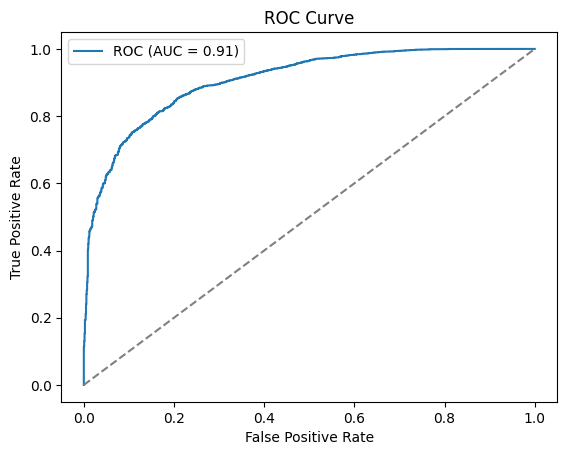

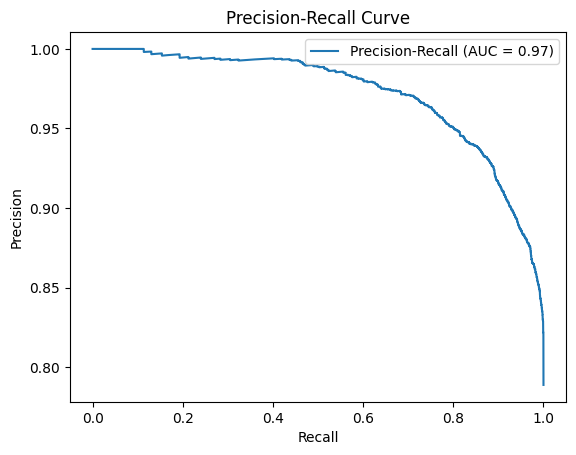

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV

# Logistic Regression Classifier setup
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Expanded hyperparameters for Logistic Regression
logreg_hyperparameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                          'penalty': ['l1', 'l2', 'elasticnet', 'none']}

# Grid search with 5-fold cross-validation
logreg_cv_grid = GridSearchCV(log_reg, logreg_hyperparameters, cv=5, scoring='roc_auc')
logreg_cv_grid.fit(train_features, train_label)

# Cross-validation results
cv_outcomes_logreg = logreg_cv_grid.cv_results_
for avg_score, std_score, hyperparam in zip(cv_outcomes_logreg['mean_test_score'], cv_outcomes_logreg['std_test_score'], cv_outcomes_logreg['params']):
    print("Average Score:", avg_score, " Standard Deviation:", std_score, " for", hyperparam)

# Best parameters and score
print('\nLogistic Regression Classifier:')
print('Optimal Hyperparameters:', logreg_cv_grid.best_params_)
print('Maximum AUC Score:', logreg_cv_grid.best_score_)

# Model evaluation
optimal_logreg = logreg_cv_grid.best_estimator_
valid_prediction_logreg = optimal_logreg.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_prediction_logreg))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_prediction_logreg))
print('Accuracy:', accuracy_score(valid_label, valid_prediction_logreg))
print('AUC Score:', roc_auc_score(valid_label, optimal_logreg.predict_proba(valid_features)[:,1]))

# ROC curve
fpr_logreg, tpr_logreg, _ = roc_curve(valid_label, optimal_logreg.predict_proba(valid_features)[:,1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'ROC (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision_logreg, recall_logreg, _ = precision_recall_curve(valid_label, optimal_logreg.predict_proba(valid_features)[:,1])
prc_auc_logreg = auc(recall_logreg, precision_logreg)
plt.figure()
plt.plot(recall_logreg, precision_logreg, label=f'Precision-Recall (AUC = {prc_auc_logreg:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Predict on test set and save to csv
test_prediction_logreg = optimal_logreg.predict(test_features)
test_df['binary_split_2'] = test_prediction_logreg
result_df_logreg = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
result_df_logreg.to_csv('LogisticReg_Result3_Submission.csv', index=False)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average F1 Score: 0.7109322150541505 with standard deviation: 0.00900689860921291 for parameters: {'C': 1}
Average F1 Score: 0.7458443012770327 with standard deviation: 0.009667828546641033 for parameters: {'C': 10}
Average F1 Score: 0.7495719742949055 with standard deviation: 0.009025175644604835 for parameters: {'C': 50}
Average F1 Score: 0.7513922227133237 with standard deviation: 0.008219395315016224 for parameters: {'C': 100}
Optimized Logistic Regression Classifier with rating cutoff of 2
Best Hyperparameters: {'C': 100}
Highest F1 Score: 0.7513922227133237
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.55      0.63      1233
           1       0.89      0.95      0.92      4605

    accuracy                           0.86      5838
   macro avg       0.81      0.75      0.77      5838
weighted avg       0.86      0.86      0.86      5838

Confusion Matrix:
 [[ 673  560]
 [ 238 4367]]
Accuracy: 0.8633093525179856
AUC S

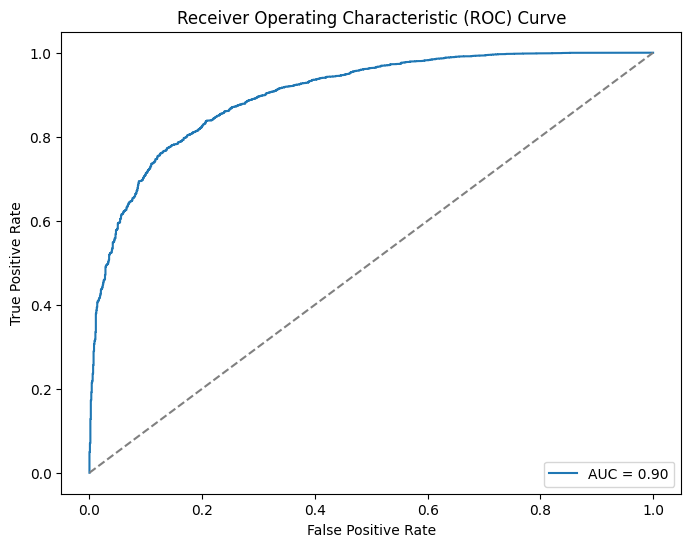

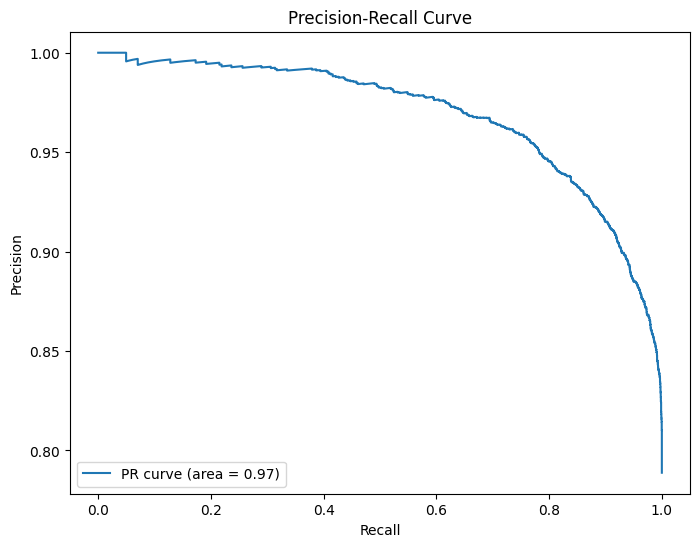

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

# Initializing the logistic regression model
logit_model = LogisticRegression(random_state=42, max_iter=1000)

# Setting the hyperparameter grid
hyperparameters = {'C': [1, 10, 50, 100]}

# Employing 5-fold cross-validation in grid search
grid_search = GridSearchCV(logit_model, hyperparameters, cv=5, scoring='f1_macro')
grid_search.fit(train_features, train_label)

# Display the mean and standard deviation of the validation scores
cv_results = grid_search.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Average F1 Score: {mean_score} with standard deviation: {std_score} for parameters: {params}")

# Show the best parameters and the corresponding score
print(f'Optimized Logistic Regression Classifier with rating cutoff of 2')
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Highest F1 Score: {grid_search.best_score_}')

# Compute the validation metrics for the optimal model
best_model = grid_search.best_estimator_
valid_predictions = best_model.predict(valid_features)
print(f'Classification Report: {classification_report(valid_label, valid_predictions)}')
print(f'Confusion Matrix:\n {confusion_matrix(valid_label, valid_predictions)}')
print(f'Accuracy: {accuracy_score(valid_label, valid_predictions)}')
print(f'AUC Score: {roc_auc_score(valid_label, best_model.predict_proba(valid_features)[:,1])}')
print(f'Macro F1 Score: {f1_score(valid_label, valid_predictions, average="macro")}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label, best_model.predict_proba(valid_features)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label, best_model.predict_proba(valid_features)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(valid_label, best_model.predict_proba(valid_features)[:,1])
auc_score = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (area = {auc_score:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

# Make predictions on test set using the optimal model
test_predictions = best_model.predict(test_features)
test_df['binary_split_2'] = test_predictions

# Create submission DataFrame and save to .csv
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('Submission_Logistic_Regression_2.csv', index=False)


Mean F1 Score: 0.5821360994705636  Standard Deviation: 0.00891426631155502  for {'max_depth': 2, 'min_samples_leaf': 1}
Mean F1 Score: 0.5824378862212812  Standard Deviation: 0.008973861048854495  for {'max_depth': 2, 'min_samples_leaf': 5}
Mean F1 Score: 0.5824378862212812  Standard Deviation: 0.008973861048854495  for {'max_depth': 2, 'min_samples_leaf': 10}
Mean F1 Score: 0.5824378862212812  Standard Deviation: 0.008973861048854495  for {'max_depth': 2, 'min_samples_leaf': 20}
Mean F1 Score: 0.5824378862212812  Standard Deviation: 0.008973861048854495  for {'max_depth': 2, 'min_samples_leaf': 50}
Mean F1 Score: 0.5824378862212812  Standard Deviation: 0.008973861048854495  for {'max_depth': 2, 'min_samples_leaf': 100}
Mean F1 Score: 0.6348434545827543  Standard Deviation: 0.008987156227835457  for {'max_depth': 5, 'min_samples_leaf': 1}
Mean F1 Score: 0.6351771556217278  Standard Deviation: 0.009110955723764216  for {'max_depth': 5, 'min_samples_leaf': 5}
Mean F1 Score: 0.63555176418

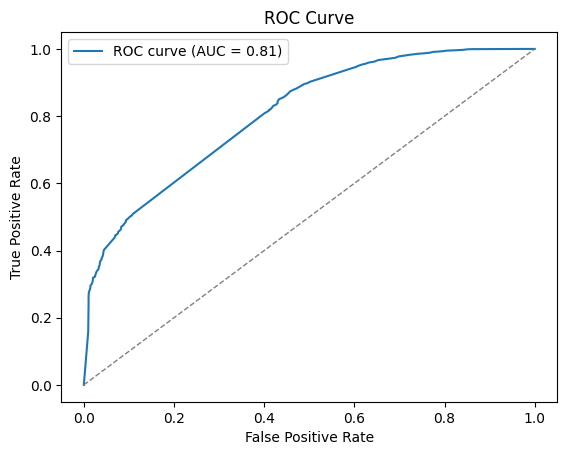

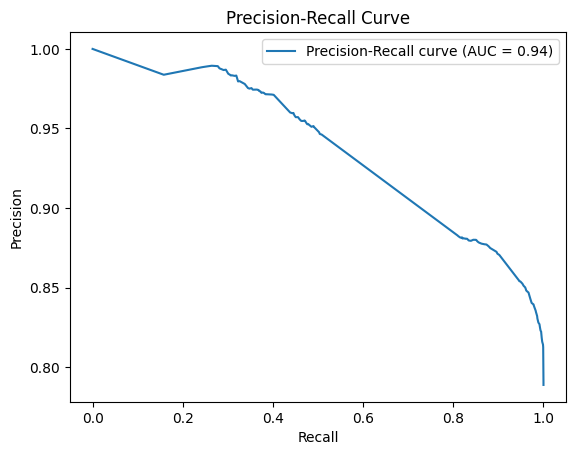

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Establishing the decision tree classifier and its hyperparameters
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_params = {'max_depth': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 20, 50, 100]}

# Applying 5-fold cross-validation for training and evaluation of the decision tree classifier
grid_cv_tree = GridSearchCV(tree_classifier, tree_params, cv=5, scoring='f1_macro')
grid_cv_tree.fit(train_features, train_label)

# Displaying mean and standard deviation of validation scores for each hyperparameter combination
validation_results_tree = grid_cv_tree.cv_results_
for avg_f1, std_f1, params in zip(validation_results_tree['mean_test_score'], validation_results_tree['std_test_score'], validation_results_tree['params']):
    print("Mean F1 Score:", avg_f1, " Standard Deviation:", std_f1, " for", params)

# Displaying the best parameters and best score
print('\nDecision Tree Classifier:')
print('Optimal Hyperparameters:', grid_cv_tree.best_params_)
print('Maximum F1 Score:', grid_cv_tree.best_score_)

# Calculating validation metrics for the best model
best_tree = grid_cv_tree.best_estimator_
valid_predictions_tree = best_tree.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_predictions_tree))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_predictions_tree))
print('Accuracy:', accuracy_score(valid_label, valid_predictions_tree))
print('AUC Score:', roc_auc_score(valid_label, best_tree.predict_proba(valid_features)[:,1]))

# Drawing ROC curve
fpr_tree, tpr_tree, _ = roc_curve(valid_label, best_tree.predict_proba(valid_features)[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, label=f'ROC curve (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Drawing precision-recall curve
prec_tree, rec_tree, _ = precision_recall_curve(valid_label, best_tree.predict_proba(valid_features)[:,1])
prc_auc_tree = auc(rec_tree, prec_tree)
plt.figure()
plt.plot(rec_tree, prec_tree, label=f'Precision-Recall curve (AUC = {prc_auc_tree:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Making predictions on the test data using the best classifier
test_predictions_tree = best_tree.predict(test_features)
test_df['predictions'] = test_predictions_tree

In [ ]:
# Making predictions on the test data using the best classifier
test_predictions_tree = best_tree.predict(test_features)
test_df['binary_split_2'] = test_predictions_tree

result_df_logreg = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
result_df_logreg.to_csv('Decision_Tree_3_2.csv', index=False)

Mean AUC Score: 0.7090791658018636  Standard Deviation: 0.012043473317525581  for {'max_depth': 5, 'min_samples_leaf': 1}
Mean AUC Score: 0.7095537095793856  Standard Deviation: 0.011373438274275153  for {'max_depth': 5, 'min_samples_leaf': 5}
Mean AUC Score: 0.7108665361773776  Standard Deviation: 0.011895089218543256  for {'max_depth': 5, 'min_samples_leaf': 10}
Mean AUC Score: 0.7116510738230544  Standard Deviation: 0.012144688578288074  for {'max_depth': 5, 'min_samples_leaf': 20}
Mean AUC Score: 0.7116903393156392  Standard Deviation: 0.012153087469695385  for {'max_depth': 5, 'min_samples_leaf': 50}
Mean AUC Score: 0.7116604936852875  Standard Deviation: 0.012265397080721262  for {'max_depth': 5, 'min_samples_leaf': 100}
Mean AUC Score: 0.7622918210961752  Standard Deviation: 0.004372708598988566  for {'max_depth': 10, 'min_samples_leaf': 1}
Mean AUC Score: 0.7674232627511834  Standard Deviation: 0.004015139314318549  for {'max_depth': 10, 'min_samples_leaf': 5}
Mean AUC Score: 0

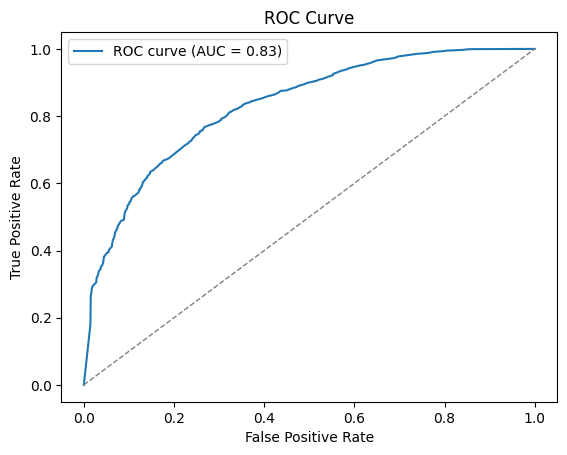

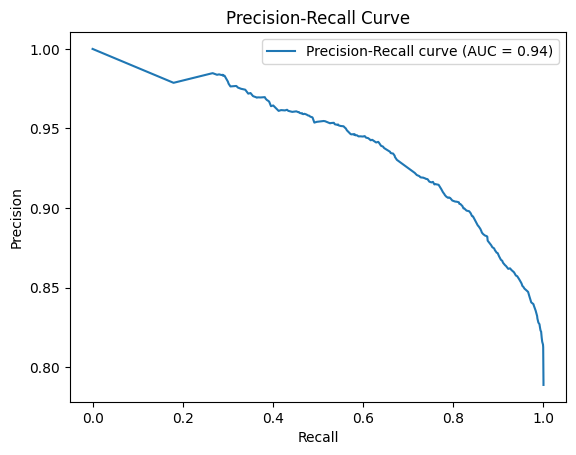

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Establishing the decision tree classifier and its hyperparameters
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_params = {'max_depth': [5, 10, 15, 20, None], 'min_samples_leaf': [1, 5, 10, 20, 50, 100]}

# Applying 5-fold cross-validation for training and evaluation of the decision tree classifier
grid_cv_tree = GridSearchCV(tree_classifier, tree_params, cv=5, scoring='roc_auc')
grid_cv_tree.fit(train_features, train_label)

# Displaying mean and standard deviation of validation scores for each hyperparameter combination
validation_results_tree = grid_cv_tree.cv_results_
for avg_score, std_score, params in zip(validation_results_tree['mean_test_score'], validation_results_tree['std_test_score'], validation_results_tree['params']):
    print("Mean AUC Score:", avg_score, " Standard Deviation:", std_score, " for", params)

# Displaying the best parameters and best score
print('\nDecision Tree Classifier:')
print('Optimal Hyperparameters:', grid_cv_tree.best_params_)
print('Maximum AUC Score:', grid_cv_tree.best_score_)

# Calculating validation metrics for the best model
best_tree = grid_cv_tree.best_estimator_
valid_predictions_tree = best_tree.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_predictions_tree))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_predictions_tree))
print('Accuracy:', accuracy_score(valid_label, valid_predictions_tree))
print('AUC Score:', roc_auc_score(valid_label, best_tree.predict_proba(valid_features)[:,1]))

# Drawing ROC curve
fpr_tree, tpr_tree, _ = roc_curve(valid_label, best_tree.predict_proba(valid_features)[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, label=f'ROC curve (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Drawing precision-recall curve
prec_tree, rec_tree, _ = precision_recall_curve(valid_label, best_tree.predict_proba(valid_features)[:,1])
prc_auc_tree = auc(rec_tree, prec_tree)
plt.figure()
plt.plot(rec_tree, prec_tree, label=f'Precision-Recall curve (AUC = {prc_auc_tree:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Making predictions on the test data using the best classifier
test_predictions_tree = best_tree.predict(test_features)
test_df['predictions'] = test_predictions_tree


In [ ]:
# Use the best classifier to make predictions on the test data
test_predictions_tree = best_tree.predict(test_features)
test_df['binary_split_2'] = test_predictions_tree

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('Decision_Tree_2_withoutSK_submission.csv', index=False)

Mean F1 Score: 0.673344498181477  Standard Deviation: 0.0045413429694756355  for {'alpha': 0.001}
Mean F1 Score: 0.6840105427465094  Standard Deviation: 0.003263308322507605  for {'alpha': 0.05}
Mean F1 Score: 0.7167062821149555  Standard Deviation: 0.008315169495592967  for {'alpha': 0.1}
Mean F1 Score: 0.5846607235594531  Standard Deviation: 0.008219571467997051  for {'alpha': 0.5}
Mean F1 Score: 0.5767078083725449  Standard Deviation: 0.009486634869417188  for {'alpha': 1}
Mean F1 Score: 0.5624323994468563  Standard Deviation: 0.006351928701000751  for {'alpha': 10}

Multinomial Naive Bayes Classifier:
Optimal Hyperparameters: {'alpha': 0.1}
Maximum F1 Score: 0.7167062821149555

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.93      0.25      0.40      1233
           1       0.83      0.99      0.91      4605

    accuracy                           0.84      5838
   macro avg       0.88      0.62      0.65      5

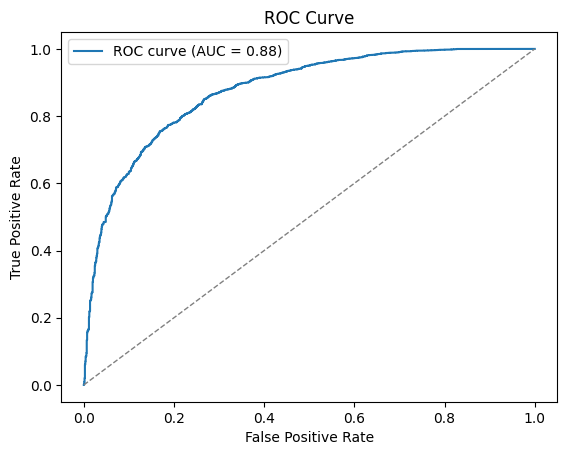

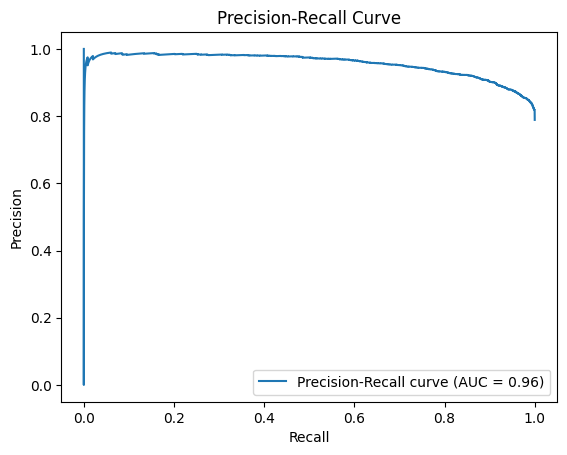

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Setting up the Multinomial Naive Bayes classifier and its hyperparameters
mnb_classifier = MultinomialNB()
mnb_params = {'alpha': [0.001, 0.05, 0.1, 0.5, 1, 10]}

# Implementing 5-fold cross-validation for training and evaluation
grid_cv_mnb = GridSearchCV(mnb_classifier, mnb_params, cv=5, scoring='f1_macro')
grid_cv_mnb.fit(train_features, train_label)

# Displaying mean and standard deviation of validation scores for each hyperparameter combination
validation_results_mnb = grid_cv_mnb.cv_results_
for avg_f1, std_f1, params in zip(validation_results_mnb['mean_test_score'], validation_results_mnb['std_test_score'], validation_results_mnb['params']):
    print("Mean F1 Score:", avg_f1, " Standard Deviation:", std_f1, " for", params)

# Displaying the best parameters and best score
print('\nMultinomial Naive Bayes Classifier:')
print('Optimal Hyperparameters:', grid_cv_mnb.best_params_)
print('Maximum F1 Score:', grid_cv_mnb.best_score_)

# Calculating validation metrics for the best model
best_mnb = grid_cv_mnb.best_estimator_
valid_predictions_mnb = best_mnb.predict(valid_features)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label, valid_predictions_mnb))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_predictions_mnb))
print('Accuracy:', accuracy_score(valid_label, valid_predictions_mnb))
print('AUC Score:', roc_auc_score(valid_label, best_mnb.predict_proba(valid_features)[:,1]))

# Drawing ROC curve
fpr_mnb, tpr_mnb, _ = roc_curve(valid_label, best_mnb.predict_proba(valid_features)[:,1])
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
plt.figure()
plt.plot(fpr_mnb, tpr_mnb, label=f'ROC curve (AUC = {roc_auc_mnb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Drawing precision-recall curve
prec_mnb, rec_mnb, _ = precision_recall_curve(valid_label, best_mnb.predict_proba(valid_features)[:,1])
prc_auc_mnb = auc(rec_mnb, prec_mnb)
plt.figure()
plt.plot(rec_mnb, prec_mnb, label=f'Precision-Recall curve (AUC = {prc_auc_mnb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Making predictions on the test data using the best classifier
test_predictions_mnb = best_mnb.predict(test_features)
test_df['predictions'] = test_predictions_mnb



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc

# Initializing the logistic regression model
logit_model = LogisticRegression(random_state=42, max_iter=1000)

# Setting the hyperparameter grid
hyperparameters = {'C': [1, 10, 50, 100]}

# Employing 5-fold cross-validation in grid search
grid_search = GridSearchCV(logit_model, hyperparameters, cv=5, scoring='f1_macro')
grid_search.fit(train_features, train_label)

# Display the mean and standard deviation of the validation scores
cv_results = grid_search.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Average F1 Score: {mean_score} with standard deviation: {std_score} for parameters: {params}")

# Show the best parameters and the corresponding score
print(f'Optimized Logistic Regression Classifier with rating cutoff of 2')
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Highest F1 Score: {grid_search.best_score_}')

# Compute the validation metrics for the optimal model
best_model = grid_search.best_estimator_
valid_predictions = best_model.predict(valid_features)
print(f'Classification Report: {classification_report(valid_label, valid_predictions)}')
print(f'Confusion Matrix:\n {confusion_matrix(valid_label, valid_predictions)}')
print(f'Accuracy: {accuracy_score(valid_label, valid_predictions)}')
print(f'AUC Score: {roc_auc_score(valid_label, best_model.predict_proba(valid_features)[:,1])}')
print(f'Macro F1 Score: {f1_score(valid_label, valid_predictions, average="macro")}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(valid_label, best_model.predict_proba(valid_features)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label, best_model.predict_proba(valid_features)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(valid_label, best_model.predict_proba(valid_features)[:,1])
auc_score = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (area = {auc_score:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

# Make predictions on test set using the optimal model
test_predictions = best_model.predict(test_features)
test_df['binary_split_2'] = test_predictions

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('Logistic_Regression_2_submission.csv', index=False)


In [ ]:
#NEW MODEL FOR LR2
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# Preprocess data
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 3 else 1)
test_df['label'] = -1

# Preprocess text
def preprocess_text(input_text):
    # Convert to lowercase
    input_text = input_text.lower()
    # Exclude punctuation, special characters and digits
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    # Trim extra spaces and newlines
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    # Exclude stop words
    stopword_list = TfidfVectorizer(stop_words='english').get_stop_words()
    word_list = input_text.split()
    word_list = [word for word in word_list if word not in stopword_list]
    input_text = ' '.join(word_list)
    return input_text

# Define the transformer for text and variables column with SelectKBest
transformer_text_vars = ColumnTransformer([
    ('review', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text)), 
                       ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'reviewText'),
    ('summary_text', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text)), 
                          ('best_k_selection', SelectKBest(f_classif, k=1000))]), 'summary'),
    ('verified_status', OneHotEncoder(), ['verified']),
    ('vote_count', 'passthrough', ['vote']) 
])

# Split the training dataset into train and validation sets
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

# Combine the text data with other relevant variables
train_features_transformed = transformer_text_vars.fit_transform(train_set[['reviewText', 'summary', 'verified', 'vote']], train_set['label'])
valid_features_transformed = transformer_text_vars.transform(valid_set[['reviewText', 'summary', 'verified', 'vote']])
test_features_transformed = transformer_text_vars.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label_transformed = train_set['label']
valid_label_transformed = valid_set['label']

# Define logistic regression classifier and its hyperparameters
log_reg = LogisticRegression(random_state=42, max_iter=1000)
logreg_hyperparameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Run grid search with 5-fold cross-validation
logreg_cv_grid = GridSearchCV(log_reg, logreg_hyperparameters, cv=5, scoring='f1')
logreg_cv_grid.fit(train_features_transformed, train_label_transformed)

# Display best parameters and score
print('\nLogistic Regression Classifier:')
print('Optimal Hyperparameters:', logreg_cv_grid.best_params_)
print('Maximum F1 Score:', logreg_cv_grid.best_score_)

# Model evaluation
optimal_logreg = logreg_cv_grid.best_estimator_
valid_prediction_logreg = optimal_logreg.predict(valid_features_transformed)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label_transformed, valid_prediction_logreg))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_prediction_logreg))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_prediction_logreg))
print('F1 Score:', f1_score(valid_label_transformed, valid_prediction_logreg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Logistic Regression Classifier:
Optimal Hyperparameters: {'C': 100}
Maximum F1 Score: 0.779277906479184

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.84      0.85      0.85      3576
           1       0.76      0.74      0.75      2262

    accuracy                           0.81      5838
   macro avg       0.80      0.80      0.80      5838
weighted avg       0.81      0.81      0.81      5838

Confusion Matrix:
 [[3054  522]
 [ 578 1684]]
Accuracy: 0.8115793079821857
F1 Score: 0.7538048343777977


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Use the best classifier to predict on test data
test_predictions = optimal_logreg.predict(test_features_transformed)
test_df['binary_split_2'] = test_predictions

# Write submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('Logistic_Regression_33_submission.csv', index=False)


In [ ]:
#NEW MODEL FOR LR2
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# Preprocess data
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 3 else 1)
test_df['label'] = -1

# Preprocess text
def preprocess_text(input_text):
    # Convert to lowercase
    input_text = input_text.lower()
    # Exclude punctuation, special characters and digits
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    # Trim extra spaces and newlines
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    # Exclude stop words
    stopword_list = TfidfVectorizer(stop_words='english').get_stop_words()
    word_list = input_text.split()
    word_list = [word for word in word_list if word not in stopword_list]
    input_text = ' '.join(word_list)
    return input_text

# Define the transformer for text and variables column with SelectKBest
transformer_text_vars = ColumnTransformer([
    ('review', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,3), preprocessor=preprocess_text)), 
                       ('best_k_selection', SelectKBest(f_classif, k=2000))]), 'reviewText'),
    ('summary_text', Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,3), preprocessor=preprocess_text)), 
                          ('best_k_selection', SelectKBest(f_classif, k=2000))]), 'summary'),
    ('verified_status', OneHotEncoder(), ['verified']),
    ('vote_count', 'passthrough', ['vote']) 
])

# Split the training dataset into train and validation sets
train_set, valid_set = train_test_split(train_df, test_size=0.2, random_state=42)

# Combine the text data with other relevant variables
train_features_transformed = transformer_text_vars.fit_transform(train_set[['reviewText', 'summary', 'verified', 'vote']], train_set['label'])
valid_features_transformed = transformer_text_vars.transform(valid_set[['reviewText', 'summary', 'verified', 'vote']])
test_features_transformed = transformer_text_vars.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label_transformed = train_set['label']
valid_label_transformed = valid_set['label']

# Define logistic regression classifier and its hyperparameters
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg_hyperparameters = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]}

# Run grid search with 5-fold cross-validation
logreg_cv_grid = GridSearchCV(log_reg, logreg_hyperparameters, cv=5, scoring='f1')
logreg_cv_grid.fit(train_features_transformed, train_label_transformed)

# Display best parameters and score
print('\nLogistic Regression Classifier:')
print('Optimal Hyperparameters:', logreg_cv_grid.best_params_)
print('Maximum F1 Score:', logreg_cv_grid.best_score_)

# Model evaluation
optimal_logreg = logreg_cv_grid.best_estimator_
valid_prediction_logreg = optimal_logreg.predict(valid_features_transformed)
print('\nModel Evaluation:')
print('Classification Report:', classification_report(valid_label_transformed, valid_prediction_logreg))
print('Confusion Matrix:\n', confusion_matrix(valid_label_transformed, valid_prediction_logreg))
print('Accuracy:', accuracy_score(valid_label_transformed, valid_prediction_logreg))
print('F1 Score:', f1_score(valid_label_transformed, valid_prediction_logreg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Logistic Regression Classifier:
Optimal Hyperparameters: {'C': 50}
Maximum F1 Score: 0.8024978714987888

Model Evaluation:
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.80      0.84      3576
           1       0.72      0.81      0.77      2262

    accuracy                           0.81      5838
   macro avg       0.80      0.81      0.80      5838
weighted avg       0.81      0.81      0.81      5838

Confusion Matrix:
 [[2878  698]
 [ 423 1839]]
Accuracy: 0.8079821856800274
F1 Score: 0.7664096686809752


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Use the best classifier to predict on test data
test_predictions = optimal_logreg.predict(test_features_transformed)
test_df['binary_split_2'] = test_predictions

# Write submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('Logistic_Regression_33_submission.csv', index=False)

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1 Score: 0.7865626403806584 +/- 0.004928988983812728 for {'C': 1}
Mean F1 Score: 0.7903330775187415 +/- 0.003101194626567702 for {'C': 10}
Mean F1 Score: 0.7876328574762638 +/- 0.0037244003843175896 for {'C': 50}
Mean F1 Score: 0.7865615621149846 +/- 0.0031879440384502762 for {'C': 100}
Logistic Regression Classifier with rating cutoff of 2
Best Parameters: {'C': 10}
Best F1 Score: 0.7903330775187415
Classification Report:               precision    recall  f1-score   support

           0       0.78      0.72      0.75      2381
           1       0.82      0.86      0.84      3457

    accuracy                           0.80      5838
   macro avg       0.80      0.79      0.79      5838
weighted avg       0.80      0.80      0.80      5838

Confusion Matrix:
 [[1707  674]
 [ 474 2983]]
Accuracy: 0.8033573141486811
AUC Score: 0.880483292850776
Macro F1 Score: 0.7934920207845746



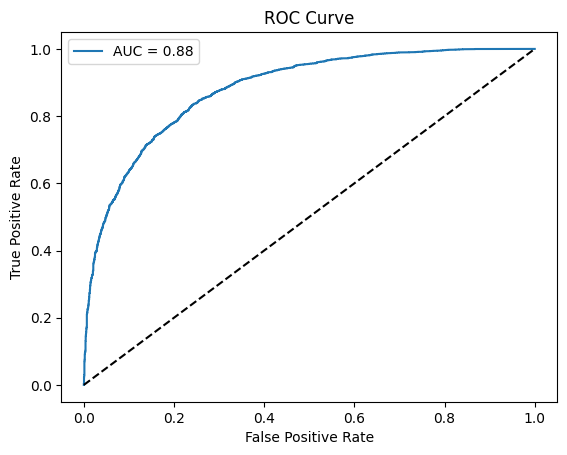

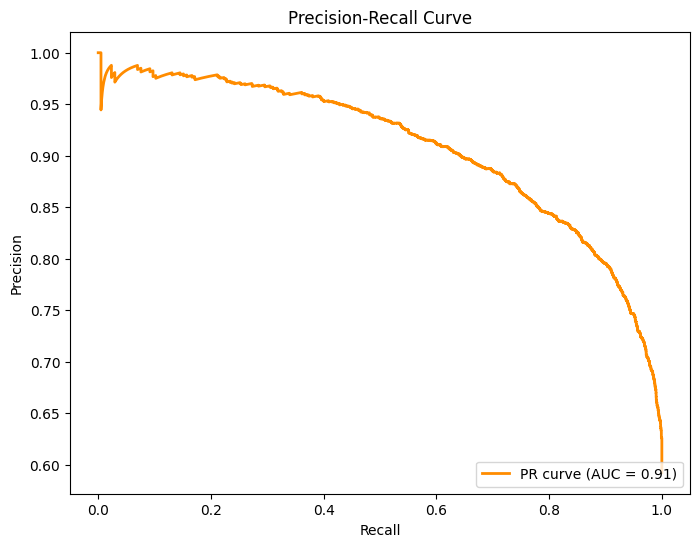

In [30]:
#Final try
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Test.csv')

train_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True)
test_df.drop(columns=['reviewerName', 'image', 'style', 'category'], inplace=True)

train_df['summary'].fillna('', inplace=True)
test_df['summary'].fillna('', inplace=True)

train_df['vote'].fillna(0, inplace=True)
test_df['vote'].fillna(0, inplace=True)

train_df['label'] = train_df['overall'].apply(lambda x: 0 if x <= 2 else 1)
test_df['label'] = -1

def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words
    stopwords = TfidfVectorizer(stop_words='english').get_stop_words()
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

# Define the text and relevant variables column transformer with SelectKBest
text_and_vars_transformer = ColumnTransformer([
    ('text', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'reviewText'),
    ('summary', TfidfVectorizer( stop_words='english', ngram_range=(1,2), preprocessor=text_preprocessing), 'summary'),
    ('verified', OneHotEncoder(), ['verified']), # Encode the 'verified' column
    ('vote', 'passthrough', ['vote'])
])

# Split the training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Concatenate the text data with other relevant variables
train_features = text_and_vars_transformer.fit_transform(train_df[['reviewText', 'summary', 'verified', 'vote']])
valid_features = text_and_vars_transformer.transform(valid_df[['reviewText', 'summary', 'verified', 'vote']])
test_features = text_and_vars_transformer.transform(test_df[['reviewText', 'summary', 'verified', 'vote']])
train_label = train_df['label']
valid_label = valid_df['label']

# Define the logistic regression classifier and its hyperparameters
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_params = {'C': [ 1, 10, 50, 100]}
#lr = LogisticRegression(random_state=42, max_iter=1000)
#lr_params = {'C': np.arange(1, 2, 0.1).tolist()}
#lr_params = {'C': np.arange(1, 20, 1).tolist()}

# Train and evaluate the logistic regression classifier using 5-fold cross-validation
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1_macro')
lr_grid.fit(train_features, train_label)

# Print the mean and standard deviation of the validation scores for each hyperparameter combination
cv_results = lr_grid.cv_results_
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean F1 Score:", mean_score, "+/-", std_score, "for", params)

# Print the results
print('Logistic Regression Classifier with rating cutoff of 2')
print('Best Parameters:', lr_grid.best_params_)
print('Best F1 Score:', lr_grid.best_score_)

# Compute the validation metrics for the best model
best_lr = lr_grid.best_estimator_
valid_pred = best_lr.predict(valid_features)
print('Classification Report:', classification_report(valid_label, valid_pred))
print('Confusion Matrix:\n', confusion_matrix(valid_label, valid_pred))
print('Accuracy:', accuracy_score(valid_label, valid_pred))
print('AUC Score:', roc_auc_score(valid_label, best_lr.predict_proba(valid_features)[:,1]))
print('Macro F1 Score:', f1_score(valid_label, valid_pred, average='macro'))
print('')

#Plot the ROC curve
fpr, tpr, thresholds = roc_curve(valid_label, best_lr.predict_proba(valid_features)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(valid_label, best_lr.predict_proba(valid_features)[:,1]):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(valid_label, best_lr.predict_proba(valid_features)[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Use the best classifier to make predictions on the test data
test_pred = best_lr.predict(test_features)
test_df['binary_split_2'] = test_pred

# Write the submission file in the required format
submission_df = pd.DataFrame({'id': test_df.index, 'binary_split_2': test_df['binary_split_2']})
submission_df.to_csv('LR2_submission.csv', index=False)